## Predicting Iowa House Prices with Linear Regression and Regularization
This project predicted house prices in Ames, Iowa with 79 features (2006-2010). The training set had 1460 observations and the test set had 1459 observations. 

I engineered features for linear regression models, and trained OLS, Lasso, Ridge, and Elastic Net in this notebook 

#### Feature Engineering:
* Outliers
* Skewness
* Missing Values (missing at random?)
* Categorical Variables (One-Hot Encoding)

#### Models:
* OLS
* Lasso
* Ridge
* Elastic Net
* Retrained models with PCA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew 
from scipy import stats

# Feature engineering
from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline

# Modeling
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

import os
import warnings
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore warnings from sklearn and seaborn

In [2]:
train = pd.read_csv('/Users/qingchuanlyu/Documents/Application/Projects/Iowa Housing/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/Users/qingchuanlyu/Documents/Application/Projects/Iowa Housing/house-prices-advanced-regression-techniques/test.csv')
train.shape, test.shape

((1460, 81), (1459, 80))

#### Feature Engineering

In [3]:
# Fix a data processing error: YrSold is earlier than YrBuilt for id 1089 in the test dataset.
test.loc[1089]["YrSold"] = 2009
test.loc[1089]["YrActualAge"] = 0

In [4]:
# The id feature doesn't have any predictive power.
train_ID = train['Id']
test_ID = test['Id']
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

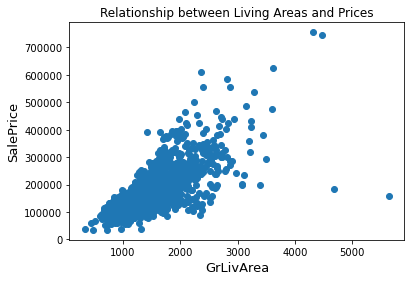

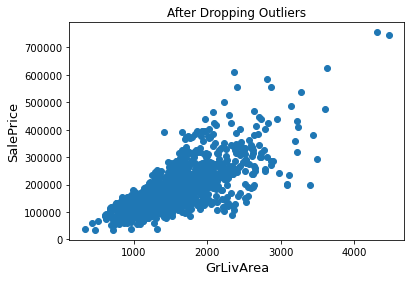

In [5]:
# What's the relationshiop between living areas and prices?
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.title('Relationship between Living Areas and Prices')
plt.show()

# Two outliers in the bottom-right corner don't follow the main stream.
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.title('After Dropping Outliers')
plt.show()


 mu = 180932.92 and sigma = 79467.79



Text(0.5, 1.0, 'SalePrice distribution (Original)')

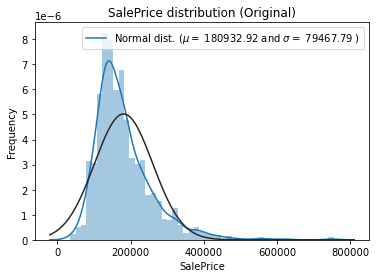

In [6]:
# Sale prices are not normally distributed.
sns.distplot(train['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc = 'best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution (Original)')


 mu = 12.02 and sigma = 0.40



Text(0.5, 1.0, 'SalePrice distribution (Log Transformed)')

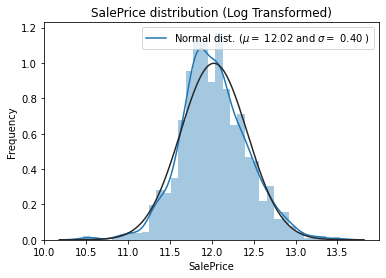

In [7]:
# Use log transformation to make right-skewed targets more normally distributed.
# Log1p(x) = log(1+x): plus 1 to avoid -inf
train["SalePrice"] = np.log1p(train["SalePrice"])

# The new distribution looks much more normally ditributed.
sns.distplot(train['SalePrice'] , fit=norm);
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution (Log Transformed)')

[Text(0.5, 1.0, 'Missing GarageType by Neighborhood')]

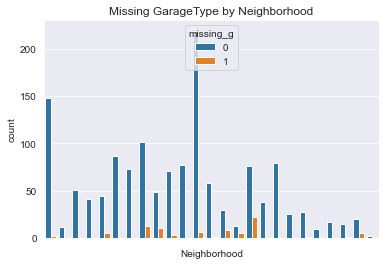

In [36]:
# Are missing values missing at random or not?
for col in ('MSSubClass', 'MasVnrType', 'BsmtQual', 'BsmtCond'\
            , 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'PoolQC'\
            , 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType'\
            , 'GarageFinish', 'GarageQual', 'GarageCond'):
    train[col] = train[col].fillna('None')
train['missing_g'] = np.where(train['GarageType']=="None", 1, 0)
# Does the distribution of the counts of garage types varies across neighborhoods?
ax = sns.countplot(x ='Neighborhood', hue = 'missing_g', data = train)
ax.set(xticklabels=[])
ax.set(title='Missing GarageType by Neighborhood')
# Missing values of garage types spread across most of few neighborhoods.

In [8]:
train.isnull().sum().sort_values(ascending = False)

PoolQC           1452
MiscFeature      1404
Alley            1367
Fence            1177
FireplaceQu       690
                 ... 
CentralAir          0
SaleCondition       0
Heating             0
TotalBsmtSF         0
MSSubClass          0
Length: 80, dtype: int64

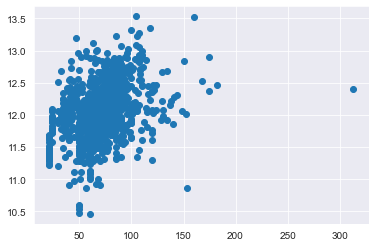

In [38]:
# LotFrontage variable is unlikely to be missing for having no lot. 
plt.scatter(train['LotFrontage'], train['SalePrice'])
# Positive correlation

In [9]:
# Do missing values of lotfrontage indicate larger or samller prices?
train.loc[train.LotFrontage.isnull() == True][['SalePrice']].mean()\
, train.loc[train.LotFrontage.isnull() == False][['SalePrice']].mean()

(SalePrice   12.062
 dtype: float64,
 SalePrice   12.016
 dtype: float64)

[Text(0.5, 1.0, 'Missing LotFrontage by Neighborhood')]

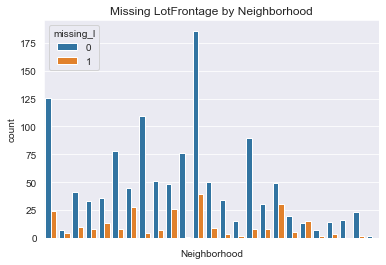

In [41]:
# Do the missing values of LotFrontage concentrate in a few neighborhoods?
train['missing_l'] = np.where(train['LotFrontage'].isnull(), 1, 0)
ax = sns.countplot(x = 'Neighborhood', hue = 'missing_l', data = train)
ax.set(xticklabels=[])
ax.set(title='Missing LotFrontage by Neighborhood')
# The missing values of LotFrontage spreads out across neighborhoods.

In [42]:
# Are the mean and median of lotfrontage different across neighborhoods?
lotfrontage_by_ngh = train.groupby(['Neighborhood'])\
                          .agg(mean_lotfrontage = ('LotFrontage', 'mean')\
                               , med_lotfrontage=('LotFrontage', 'median'))\
                          .reset_index()

In [43]:
lotfrontage_by_ngh.head(15)

,Neighborhood,mean_lotfrontage,med_lotfrontage
0,Blmngtn,47.143,43.000
1,Blueste,24.000,24.000
2,BrDale,21.562,21.000
3,BrkSide,57.510,52.000
4,ClearCr,83.462,80.000
5,CollgCr,71.683,70.000
6,Crawfor,71.805,74.000
7,Edwards,64.811,64.500
8,Gilbert,79.878,65.000
9,IDOTRR,62.500,60.000


In [44]:
# The median of LotFrontage varies by neighborhoods.
nbh_lot = train.groupby(train.Neighborhood)[['LotFrontage']].median()
train = train.merge(nbh_lot, on=["Neighborhood"], how='left', suffixes=('','_'))
train['LotFrontage'] = train['LotFrontage'].fillna(train['LotFrontage_']).astype(int)
train = train.drop('LotFrontage_', axis=1)

In [45]:
# Replacing missing data with 0:
# GarageYrBlt, GarageArea and GarageCars: 
# Beacuse having no garage is equivalent to having no cars in such a garage;
# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : 
# Because missing values are likely zero for having no basement.
for col in ('MasVnrArea', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    train[col] = train[col].fillna(0)
# Utilities feature is a singleton.
train = train.drop(['Utilities'], axis=1)
# Data description says NA means 'Typical' in the Functional feature.
train["Functional"] = train["Functional"].fillna("Typical")
# For features with only one NA value, use mode of this var in the training set.
for col in ('KitchenQual', 'Electrical', 'Exterior1st', 'Exterior2nd', 'MSZoning', 'SaleType'):
    train[col] = train[col].fillna(train[col].mode()[0])

In [46]:
# Categorize categorical variables stored as numerical variables.
train['OverallCond'] = train['OverallCond'].apply(str)
train['YrSold'] = train['YrSold'].astype(str)
train['MoSold'] = train['MoSold'].astype(str)

In [47]:
cates = train.select_dtypes(include=['object', 'category']).columns
for c in cates:
    lbl = LabelEncoder() 
    lbl.fit(list(train[c])) 
    train[c] = lbl.transform(list(train[c]))

In [48]:
# Omit orders indicated by label encoders.
# PCA with One-Hot Encoder is not very meaningful, but it works.
train = pd.get_dummies(train)
print(train.shape)

(1458, 81)


In [49]:
num_vars = train.dtypes[(train.dtypes != "object") & (train.dtypes != 'category')].index
skewed_vars = train[num_vars].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_vars})
skewness.head(15)
skewness = skewness[abs(skewness) > 0.8]
skewed_features = skewness.index
lam = 0.25
for f in skewed_features:
    train[f] = boxcox1p(train[f], lam)

In [50]:
y_train = train.SalePrice.values
train = train.drop('SalePrice', axis = 1)

#### Modeling

In [51]:
metric = 'neg_root_mean_squared_error'
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [52]:
# OLS.
print(f"{(-cross_val_score(LinearRegression(), train, y_train, cv=kfold, scoring=metric)).mean():.4f} Error")

0.1245 Error


In [53]:
# Lasso.
lasso = Lasso(alpha= 0.003, random_state=1)
param_grid_lasso = {
                    'alpha' : np.linspace(0.0001, 0.001, 10)
                    }
search_lasso = GridSearchCV(estimator = lasso, param_grid=param_grid_lasso, cv=10, scoring=metric, n_jobs=-1)
search_lasso.fit(train, y_train)
print(f"{search_lasso.cv_results_['std_test_score'][search_lasso.best_index_]}")
# Mean cross-validated score of the best_estimator
print(f"{(-search_lasso.best_score_):.4}")

0.011563679401077775
0.1193


In [54]:
# Ridge.
ridge = Ridge(alpha= 0.003, random_state=1)
param_grid_ridge = {
                    'alpha' : np.linspace(0.0001, 0.001, 10)
                    }
search_ridge = GridSearchCV(estimator = ridge, param_grid = param_grid_ridge, cv=10, scoring=metric, n_jobs=-1)
search_ridge.fit(train, y_train)
print(f"{search_ridge.best_params_}")
print(f"{(-search_ridge.best_score_):.4}")

{'alpha': 0.001}
0.1205


In [56]:
# Elastic Net.
elastic_net = ElasticNet(alpha= 0.0005, 
                         l1_ratio= 0.4, 
                         random_state=1)
param_grid_el = {
                'alpha' : np.linspace(0.0001, 0.001, 10),
                'l1_ratio' : np.linspace(0.6, 0.95, 20)
                }
search_el = GridSearchCV(estimator = elastic_net, param_grid = param_grid_el, cv=10, scoring=metric, n_jobs=-1)
search_el.fit(train, y_train)
print(f"{search_el.best_params_}")
print(f"{search_el.cv_results_['std_test_score'][search_el.best_index_]}")
print(f"{(-search_el.best_score_):.4}")

{'alpha': 0.00019999999999999998, 'l1_ratio': 0.95}
0.011566964621977344
0.1193


In [57]:
# Re-train models with PCA.
scaler = StandardScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)
# Choose the minimum number of principal components such that 95% of the variance is retained.
pca = PCA(.95)
pca.fit(train_scaled)
train_pca = pca.transform(train_scaled)

In [58]:
# OLS with PCA.
print(f"{(-cross_val_score(LinearRegression(), train_pca, y_train, cv=kfold, scoring=metric)).mean():.4f} Error")

0.1286 Error


In [59]:
# Lasso with PCA.
lasso_pca = Lasso(alpha= 0.003, random_state=1)
param_grid = {
              'alpha' : np.linspace(0.0001, 0.001, 10)
             }
search = GridSearchCV(lasso_pca, param_grid, cv=10, scoring=metric, n_jobs=-1)
search.fit(train_pca, y_train)
print(f"{search.best_params_}")
print(f"{(-search.best_score_):.4}")

{'alpha': 0.0007999999999999999}
0.1271


In [60]:
# Ridge with PCA.
ridge_pca = Ridge(alpha= 0.003, random_state=1)
param_grid = {
              'alpha' : np.linspace(0.0001, 0.001, 10)
             }
search = GridSearchCV(ridge_pca, param_grid, cv=10, scoring=metric, n_jobs=-1)
search.fit(train_pca, y_train)
print(f"{search.best_params_}")
print(f"{(-search.best_score_):.4}")

{'alpha': 0.001}
0.1273


In [61]:
# Elastic Net with PCA.
elastic_net_pca = ElasticNet(alpha= 0.0005, 
                  l1_ratio= 0.4, 
                  random_state=1)
param_grid = {
              'alpha' : np.linspace(0.0001, 0.001, 10),
              'l1_ratio' : np.linspace(0.6, 0.95, 20)
              }
search = GridSearchCV(elastic_net_pca, param_grid, cv=10, scoring=metric, n_jobs=-1)
search.fit(train_pca, y_train)
print(f"{search.best_params_}")
print(f"{search.cv_results_['std_test_score'][search.best_index_]}")
print(f"{(-search.best_score_):.4}")

{'alpha': 0.001, 'l1_ratio': 0.7473684210526316}
0.012151000090009969
0.1271
